In [1]:
!pip install vaderSentiment

In [2]:
!pip install nrclex


In [3]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
!pip install textblob

In [5]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
from nrclex import NRCLex
from textblob import TextBlob

In [6]:
movies = pd.read_csv('imdb-movies-dataset.csv')
movies.head()

,Poster,Title,Year,Certificate,Duration (min),Genre,Rating,Metascore,Director,Cast,Votes,Description,Review Count,Review Title,Review
0,https://m.media-amazon.com/images/M/MV5BYWRkZj...,The Idea of You,2023.0,R,115.0,"Comedy, Drama, Romance",6.4,67.0,Michael Showalter,"Anne Hathaway, Nicholas Galitzine, Ella Rubin,...","28,744","Solène, a 40-year-old single mom, begins an un...",166,Hypocrisy as an idea,"This film, as well as the reaction to it, is a..."
1,https://m.media-amazon.com/images/M/MV5BZGI4NT...,Kingdom of the Planet of the Apes,2023.0,PG-13,145.0,"Action, Adventure, Sci-Fi",7.3,66.0,Wes Ball,"Owen Teague, Freya Allan, Kevin Durand, Peter ...","22,248","Many years after the reign of Caesar, a young ...",183,A phenomenal start to another trilogy!,"I'm a big fan of all the planet of the apes, a..."
2,https://m.media-amazon.com/images/M/MV5BZjIyOT...,Unfrosted,2023.0,PG-13,97.0,"Biography, Comedy, History",5.5,42.0,Jerry Seinfeld,"Isaac Bae, Jerry Seinfeld, Chris Rickett, Rach...","18,401","In 1963 Michigan, business rivals Kellogg's an...",333,not funny,Pretty much the worst criticism you can lay on...
3,https://m.media-amazon.com/images/M/MV5BMjA5Zj...,The Fall Guy,2023.0,PG-13,126.0,"Action, Comedy, Drama",7.3,73.0,David Leitch,"Ryan Gosling, Emily Blunt, Aaron Taylor-Johnso...","38,953",A down-and-out stuntman must find the missing ...,384,Everything you needed and more!,Just got out of the Austin premier at SXSW and...
4,https://m.media-amazon.com/images/M/MV5BNTk1MT...,Challengers,2023.0,R,131.0,"Drama, Romance, Sport",7.7,82.0,Luca Guadagnino,"Zendaya, Mike Faist, Josh O'Connor, Darnell Ap...","32,517","Tashi, a former tennis prodigy turned coach, t...",194,"Watch ""Match Point"" instead",This is a tough one. I liked the concept and t...


In [7]:
movies.columns

Index(['Poster', 'Title', 'Year', 'Certificate', 'Duration (min)', 'Genre',
       'Rating', 'Metascore', 'Director', 'Cast', 'Votes', 'Description',
       'Review Count', 'Review Title', 'Review'],
      dtype='object')

In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Poster          10000 non-null  object 
 1   Title           10000 non-null  object 
 2   Year            9850 non-null   float64
 3   Certificate     7370 non-null   object 
 4   Duration (min)  9664 non-null   float64
 5   Genre           9993 non-null   object 
 6   Rating          9596 non-null   float64
 7   Metascore       7555 non-null   float64
 8   Director        9995 non-null   object 
 9   Cast            9961 non-null   object 
 10  Votes           9596 non-null   object 
 11  Description     10000 non-null  object 
 12  Review Count    9999 non-null   object 
 13  Review Title    9483 non-null   object 
 14  Review          9484 non-null   object 
dtypes: float64(4), object(11)
memory usage: 1.1+ MB


In [9]:
movies.isnull().sum()

,0
Poster,0
Title,0
Year,150
Certificate,2630
Duration (min),336
Genre,7
Rating,404
Metascore,2445
Director,5
Cast,39


In [10]:
movies=movies.dropna()

In [11]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6404 entries, 0 to 9998
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Poster          6404 non-null   object 
 1   Title           6404 non-null   object 
 2   Year            6404 non-null   float64
 3   Certificate     6404 non-null   object 
 4   Duration (min)  6404 non-null   float64
 5   Genre           6404 non-null   object 
 6   Rating          6404 non-null   float64
 7   Metascore       6404 non-null   float64
 8   Director        6404 non-null   object 
 9   Cast            6404 non-null   object 
 10  Votes           6404 non-null   object 
 11  Description     6404 non-null   object 
 12  Review Count    6404 non-null   object 
 13  Review Title    6404 non-null   object 
 14  Review          6404 non-null   object 
dtypes: float64(4), object(11)
memory usage: 800.5+ KB


In [12]:
movies.describe()

,Year,Duration (min),Rating,Metascore
count,6404.000000,6404.000000,6404.000000,6404.000000
mean,2006.289975,110.068395,6.548782,57.363991
std,18.284315,19.477238,0.938561,17.629282
min,1929.000000,55.000000,1.900000,1.000000
25%,1997.000000,97.000000,6.000000,45.000000
50%,2012.000000,107.000000,6.600000,57.000000
75%,2021.000000,119.000000,7.200000,70.000000
max,2025.000000,321.000000,9.300000,100.000000


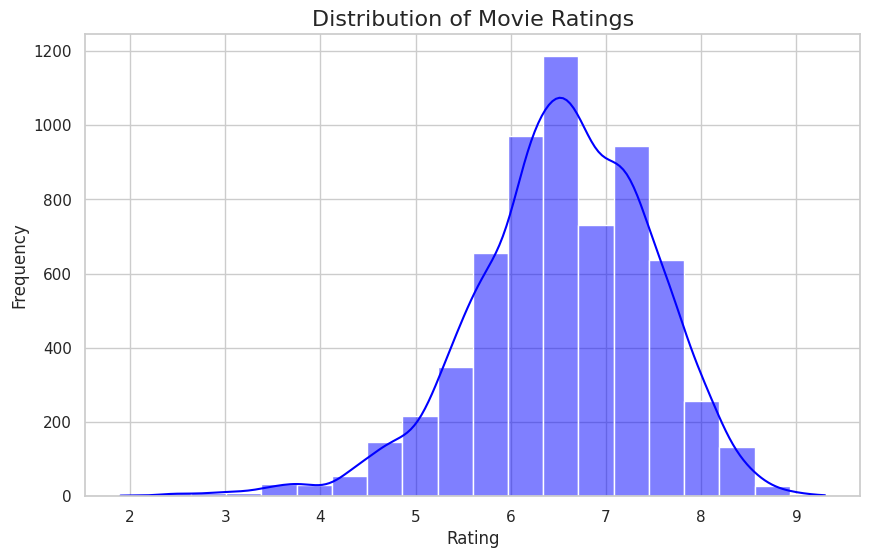

In [13]:
sns.set(style="whitegrid")

# Plot the distribution of movie ratings
plt.figure(figsize=(10,6))
sns.histplot(movies['Rating'], bins=20, kde=True, color='blue')

plt.title('Distribution of Movie Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [14]:
# Download the lexicon
nltk.download('vader_lexicon')


analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
# Function to compute sentiment score
def get_sentiment(review):
    if pd.isna(review):
        return 0
    sentiment = analyzer.polarity_scores(review)
    return sentiment['compound']

# Apply sentiment analysis to the 'Review' column (optional)
movies['Sentiment_Score'] = movies['Review'].apply(get_sentiment)

In [16]:
# Download the necessary NLTK data
nltk.download('punkt_tab')

# Function to detect emotions using NRC Lexicon
def detect_emotions(review):
    if pd.isna(review):
        return []

    emotion = NRCLex(review)
    return emotion.top_emotions

# Apply emotion detection to the 'Review' column
movies['Emotion_Scores'] = movies['Review'].apply(detect_emotions)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [17]:
# Function to extract the dominant emotion from the scores
def extract_dominant_emotion(emotion_scores):
    if not emotion_scores:
        return 'neutral'

    # Return the emotion with the highest probability
    dominant_emotion = max(emotion_scores, key=lambda item: item[1])[0]
    return dominant_emotion

# Apply the dominant emotion extraction
movies['Dominant_Emotion'] = movies['Emotion_Scores'].apply(extract_dominant_emotion)

In [18]:
# View the updated dataframe (optional)
print(movies[['Title', 'Dominant_Emotion', 'Sentiment_Score']].head())

                               Title Dominant_Emotion  Sentiment_Score
0                    The Idea of You         positive           0.8934
1  Kingdom of the Planet of the Apes         positive           0.9792
2                          Unfrosted         positive           0.9672
3                       The Fall Guy         positive           0.9939
4                        Challengers         positive           0.9130


In [19]:
def recommend_movies_by_emotion(emotion, top_n=5):
    # Define emotion groups for flexible matching
    emotion_groups = {
        'fearful': ['fear', 'anticipation', 'surprise', 'negative'],
        'happy': ['joy', 'trust', 'positive'],
        'sad': ['sadness', 'disgust', 'negative'],
        'angry': ['anger', 'disgust', 'negative'],
        'surprised': ['surprise', 'anticipation'],
        'neutral': ['neutral', 'positive'],
        'relaxed' : ['neutral','joy','trust'],
        'excited': ['joy', 'trust', 'positive']


    }

    # Expand the emotion filter to include related emotions
    if emotion in emotion_groups:
        filtered_emotions = emotion_groups[emotion]
        emotion_filtered = movies[movies['Dominant_Emotion'].isin(filtered_emotions)]
    else:
        emotion_filtered = movies[movies['Dominant_Emotion'] == emotion]

    # Sort the movies by Rating and return the top N
    recommendations = emotion_filtered.sort_values(by='Rating', ascending=False).head(top_n)
    return recommendations[['Title', 'Rating', 'Dominant_Emotion', 'Description']]


In [20]:
def print_recommendations(user_emotion):
  if user_emotion in available_emotions:
    # Recommend movies based on the selected or related emotions
    top_movies = recommend_movies_by_emotion(user_emotion)
    print("Top recommended movies based on your emotion:")

    # Display the results in a more organized way using a loop
    if not top_movies.empty:
        for index, row in top_movies.iterrows():
            print(f"\nTitle: {row['Title']}")
            print(f"Rating: {row['Rating']}")
            print(f"Dominant Emotion: {row['Dominant_Emotion']}")
            print(f"Description: {row['Description']}")
    else:
        print("No movies found matching your selected emotion.")
  else:
    print("Invalid emotion selected. Please choose from the available options.")

In [21]:
# Get user input for emotion
available_emotions = ['happy', 'sad', 'neutral', 'excited', 'angry', 'fearful', 'surprised', 'relaxed']
user_emotion = input(f"Choose an emotion from {available_emotions}: ").lower()

print_recommendations(user_emotion)

Choose an emotion from ['happy', 'sad', 'neutral', 'excited', 'angry', 'fearful', 'surprised', 'relaxed']: angry
Top recommended movies based on your emotion:

Title: 12 Angry Men
Rating: 9.0
Dominant Emotion: negative
Description: The jury in a New York City murder trial is frustrated by a single member whose skeptical caution forces them to more carefully consider the evidence before jumping to a hasty verdict.

Title: The Shining
Rating: 8.4
Dominant Emotion: negative
Description: A family heads to an isolated hotel for the winter where a sinister presence influences the father into violence, while his psychic son sees horrific forebodings from both past and future.

Title: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb
Rating: 8.4
Dominant Emotion: negative
Description: An unhinged American general orders a bombing attack on the Soviet Union, triggering a path to nuclear holocaust that a war room full of politicians and generals frantically tries to stop.

Tit